# DDPG PROJECT

Import gym and define pendulum environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import copy

Check API-conformity

In [3]:
from gym.utils.env_checker import check_env

Import helpers

In [4]:
from helpers import *

## 3) Heuristic policy

##### Wrap environment in a NormalizedEnv class

In [5]:
env = gym.make('Pendulum-v1', g=9.81)
env = NormalizedEnv(env)

##### RandomAgent

In [6]:
random_agent = RandomAgent(env)
rewards = np.zeros((10,200))

for i in range(10):
    state = env.reset()
    state = state[0]
    
    trunc = False
    cur_reward = []
    
    while not trunc:   
        action = random_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)
        
        if term or trunc:
            observation, info = env.reset()
    
    rewards[i] = cur_reward

rand_rewards = rewards

C:\Users\franc\anaconda3\envs\ann_2\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


##### Heuristic pendulum agent

In [7]:
heur_agent = HeuristicPendulumAgent(env, 1)
rewards = np.zeros((10,200))

for i in range(10):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = heur_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

heur_rewards = rewards

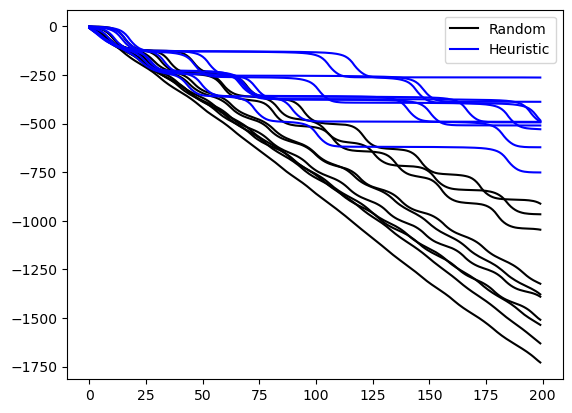

In [8]:
plt.figure()
plt.plot(np.arange(200), np.cumsum(rand_rewards[0]),'k',label='Random')
plt.plot(np.arange(200), np.cumsum(heur_rewards[0]),'b', label='Heuristic')
plt.legend()
[plt.plot(np.arange(200), np.cumsum(rand_rewards[i]),'k') for i in range(1,len(rand_rewards))]
[plt.plot(np.arange(200), np.cumsum(heur_rewards[i]),'b') for i in range(1,len(heur_rewards))]
plt.show()

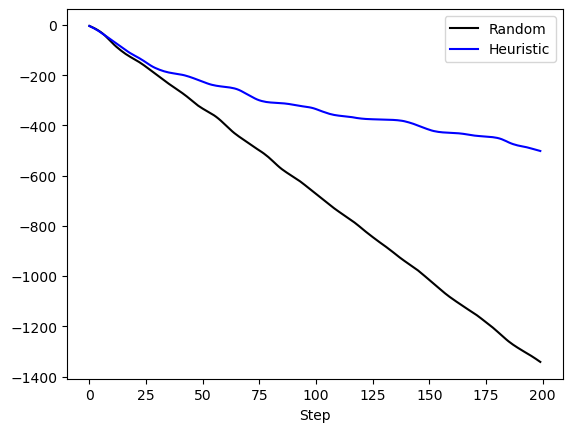

In [9]:
plt.figure()
plt.plot(np.arange(200), np.mean(np.cumsum(rand_rewards, axis = 1), axis = 0),'k',label='Random')
plt.plot(np.arange(200), np.mean(np.cumsum(heur_rewards, axis = 1), axis = 0),'b', label='Heuristic')
plt.xlabel('Step')
plt.legend()
plt.savefig('Plots/Heur_rewards.png')

Effect of fixed torque

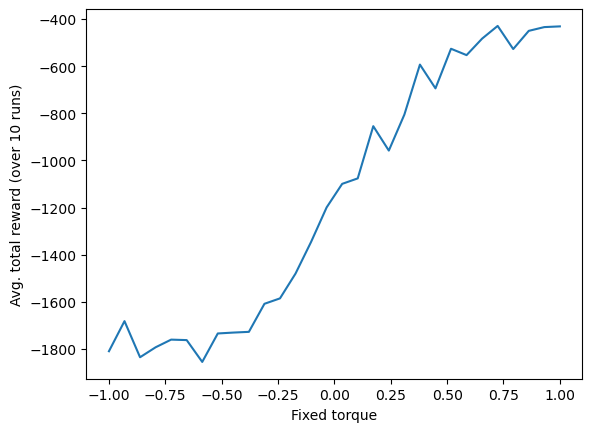

In [14]:
torques = np.linspace(-1,1,30)
avg_rewards = []

for t in torques:
    heur_agent = HeuristicPendulumAgent(env,t)
    rewards = []

    for _ in range(20):
        state = env.reset()
        state = state[0]

        trunc = False
        cur_reward = 0

        while not trunc:
            action = heur_agent.compute_action(state) 
            (next_state, reward, term, trunc, info) = env.step(action)
            state = next_state
            cur_reward += reward

            if term or trunc:
                observation, info = env.reset()

        rewards.append(cur_reward)
    avg_rewards.append(np.mean(rewards))

plt.figure()
plt.plot(torques, avg_rewards)
plt.xlabel('Fixed torque')
plt.ylabel('Avg. total reward (over 10 runs)')
plt.savefig('Plots/Torque_effect.png')
plt.show()


## 4) Q function of the heuristic policy

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [11]:
def train_epoch(model, agent, optimizer, criterion, gamma, Buffer, epoch):
    #model.eval()
    state = env.reset()
    state = state[0]
    Trunc = False
    loss_epoch = []
    while not Trunc:
        with torch.no_grad():
            action = agent.compute_action(state) 
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
        if (len(Buffer.buffer) >= 128):
            #model.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,4))
            reward = np.zeros(128)
            next_data = np.zeros((128,4))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):  
                data[i] = np.concatenate((transition[0], transition[1]))
                reward[i] = transition[2]
                trunc[i] = transition[4]
                with torch.no_grad(): 
                    try:                        
                        next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3], deterministic = True)))
                    except:
                        next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3])))                       

            data = torch.tensor(data, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)
            next_data = torch.tensor(next_data, dtype=torch.float32)
            trunc = torch.tensor(trunc, dtype = torch.bool)

            optimizer.zero_grad()
            output = model(data)  # (state, action) -> Q(s, a)
            with torch.no_grad():
                target = (reward + gamma*model(next_data).flatten()).reshape(128,1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
               
    return np.mean(loss_epoch)

In [13]:
heur_agent = HeuristicPendulumAgent(env,0.8)
max_size = 1e4

model = QNetwork()
# model_start = copy.deepcopy(model)
lr = 1e-4
gamma = 0.99
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.MSELoss()
num_epochs = 1000
Buffer = ReplayBuffer(max_size = max_size)

net_dir = 'Models/Q_network'
if not os.path.exists(net_dir):
    os.makedirs(net_dir)

try:
    model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))
    print('Loading network')

except:
    history = []
    for epoch in range(num_epochs):
        loss = train_epoch(model, heur_agent, optimizer, criterion, gamma, Buffer, epoch)
        if epoch%10 == 0:
            print(f'Epoch: {epoch}, loss: {loss:.3f}')
        history.append(loss)
    
    torch.save(model.state_dict(), net_dir+'/model.pt')
    np.save(net_dir+'/history.npy', history)
    model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))

Loading network


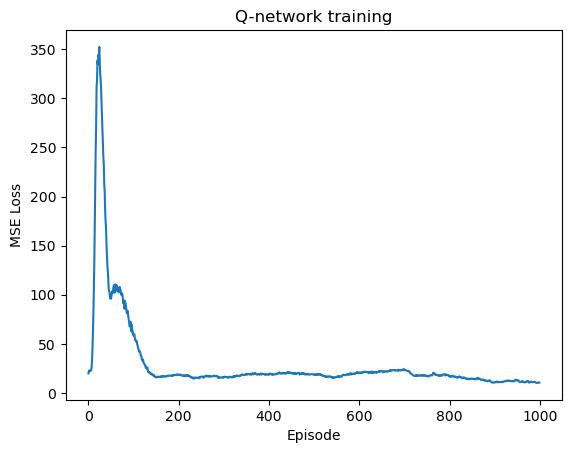

In [14]:
history = np.load(net_dir+'/history.npy')
plt.plot(np.arange(len(history)), history)
plt.xlabel('Episode')
plt.ylabel('MSE Loss')
plt.title('Q-network training')
plt.savefig(f'Plots/Q_training_{len(history)}.png')

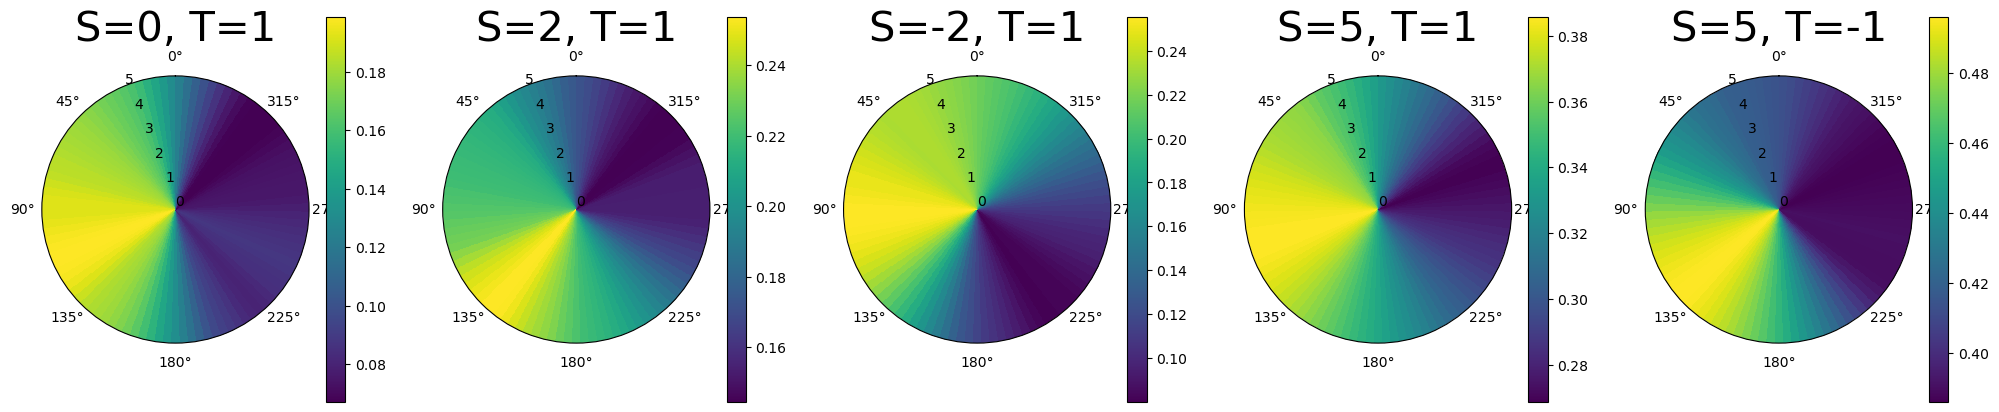

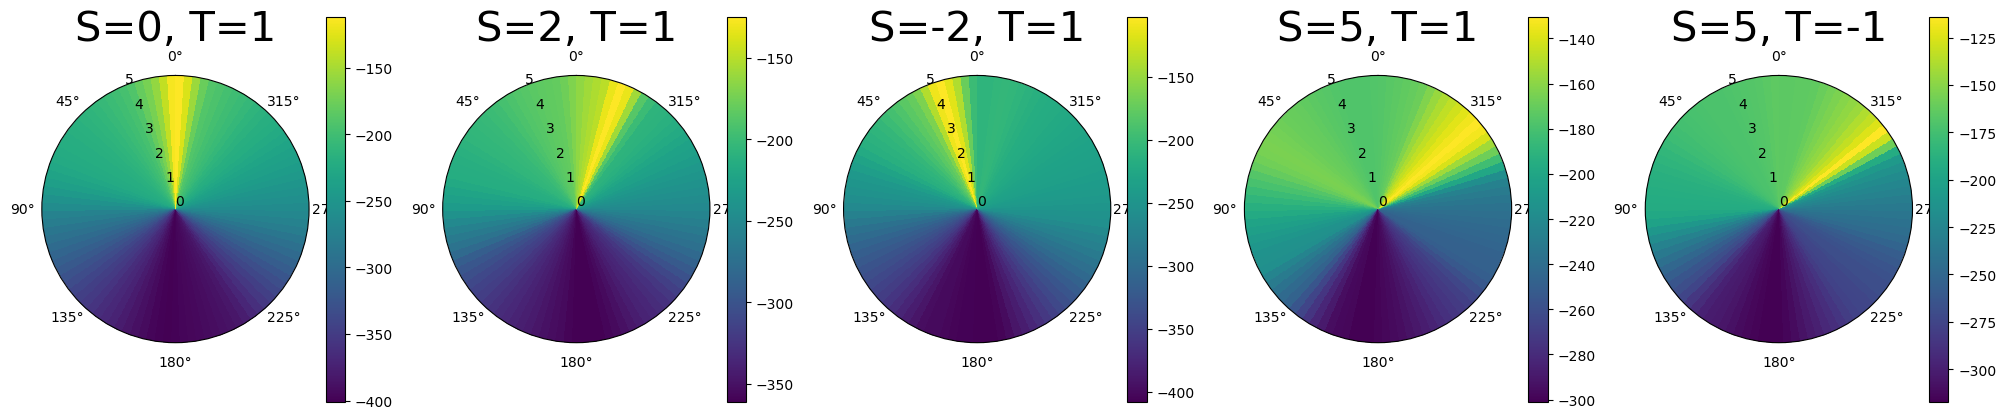

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

net_dir = 'Models/Q_network'
model = QNetwork()
model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))
model_start = QNetwork()
logs = [(0,1),(2,1),(-2,1),(5,1),(5,-1)]

fig, axs = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection': 'polar'})

for i,l in enumerate(logs):
    speed = l[0]
    torque = l[1]
        
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = model_start(data)
    z = z.detach().numpy().squeeze()
    
    ax = axs[i]
    ax.grid(False)
    pc = ax.pcolormesh(th, r, z)
    ax.plot(azm, r, color='k', ls='none') 
    ax.set_theta_zero_location('N')
    fig.colorbar(pc, ax=ax)
    ax.set_title(f'S={speed}, T={torque}',fontsize=30)

plt.savefig(f'Plots/Q_heat_pre.png', bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection': 'polar'})

for i,l in enumerate(logs):
    speed = l[0]
    torque = l[1]
        
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = model(data)
    z = z.detach().numpy().squeeze()
    
    ax = axs[i]
    ax.grid(False)
    pc = ax.pcolormesh(th, r, z)
    ax.plot(azm, r, color='k', ls='none') 
    ax.set_theta_zero_location('N')
    fig.colorbar(pc, ax=ax)
    ax.set_title(f'S={speed}, T={torque}',fontsize=30)

plt.savefig(f'Plots/Q_heat.png', bbox_inches='tight')
plt.show()

## 5) Minimal Implementation of DDPG

In [13]:
def compute_loss_policy(state, action, model_Q):
    data = torch.cat((state, action), axis = 1)
    loss_policy = torch.mean(-model_Q(data))
    return loss_policy

'''
def train_epoch_policy(model_policy, model_Q, agent, optimizer, criterion, gamma, Buffer, epoch):
    state = env.reset()
    state = state[0]

    Trunc = False
    loss_epoch = []
    while not Trunc:
        #model_policy.eval()
        with torch.no_grad():
            action = agent.compute_action(state)
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
    
        if len(Buffer.buffer) >= 128:
            #model_Q.eval()
            #model_policy.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,3))
            reward = np.zeros(128)
            next_data = np.zeros((128,3))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):        
                data[i] = transition[0]
                reward[i] = transition[2]
                trunc[i] = transition[4]
                next_data[i] = transition[3]

            data = torch.tensor(data, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)
            next_data = torch.tensor(next_data, dtype=torch.float32)
            trunc = torch.tensor(trunc, dtype = torch.bool)
            optimizer.zero_grad()
            output = model_policy(data)  # state -> action
            
            loss = compute_loss_policy(data, output, model_Q)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())

    return np.mean(loss_epoch)
'''

'\ndef train_epoch_policy(model_policy, model_Q, agent, optimizer, criterion, gamma, Buffer, epoch):\n    state = env.reset()\n    state = state[0]\n\n    Trunc = False\n    loss_epoch = []\n    while not Trunc:\n        #model_policy.eval()\n        with torch.no_grad():\n            action = agent.compute_action(state)\n        (next_state, reward, term, Trunc, info) = env.step(action)\n        Buffer.store_transition((state, action, reward, next_state, Trunc))\n        state = next_state\n    \n        if len(Buffer.buffer) >= 128:\n            #model_Q.eval()\n            #model_policy.train()\n            b = Buffer.batch_buffer(128)\n            data = np.zeros((128,3))\n            reward = np.zeros(128)\n            next_data = np.zeros((128,3))\n            trunc = np.zeros(128)\n            for i,transition in enumerate(b):        \n                data[i] = transition[0]\n                reward[i] = transition[2]\n                trunc[i] = transition[4]\n                nex

In [14]:
def train_epoch_ddpg(model_policy, model_Q, agent, optimizer_policy, optimizer_Q, criterion, gamma, Buffer, epoch):
    state = env.reset()
    state = state[0]

    Trunc = False
    loss_epoch_Q = []
    loss_epoch_policy = []
    cur_rew = 0
    while not Trunc:
        with torch.no_grad():
            action = agent.compute_action(state)
        (next_state, reward, term, Trunc, info) = env.step(action)
        cur_rew += reward
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
    
        if len(Buffer.buffer) >= 128:
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,4))
            reward = np.zeros(128)
            next_data = np.zeros((128,4))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):  
                data[i] = np.concatenate((transition[0], transition[1]))
                reward[i] = transition[2]
                trunc[i] = transition[4]
                with torch.no_grad(): 
                    next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3], deterministic = True)))

            data = torch.tensor(data, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)
            next_data = torch.tensor(next_data, dtype=torch.float32)
            trunc = torch.tensor(trunc, dtype = torch.bool)

            optimizer_Q.zero_grad()
            optimizer_policy.zero_grad()

            output_Q = model_Q(data)  # (state, action) -> Q
            with torch.no_grad():
                target = (reward + gamma*model_Q(next_data).flatten()).reshape(128,1)
            loss_Q = criterion(output_Q, target) 
            loss_Q.backward()
            optimizer_Q.step()

            output_policy = model_policy(data[:, :3])  # state -> action            
            loss_policy = compute_loss_policy(data[:, :3], output_policy, model_Q)
            loss_policy.backward()
            optimizer_policy.step()
            
            loss_epoch_Q.append(loss_Q.item())
            loss_epoch_policy.append(loss_policy.item())

    return np.mean(loss_epoch_Q), np.mean(loss_epoch_policy), cur_rew

In [ ]:
# Define DDPG agent
noise_std = 0.3
ddpg_agent = DDPGAgent(noise_std)
ddpg_agent_start = copy.deepcopy(ddpg_agent)

max_size = 1e5
Buffer = ReplayBuffer(max_size = max_size)

# Training parameters, ecc...
lr = 1e-4
gamma = 0.99
optimizer_Q = torch.optim.Adam(ddpg_agent.Q_network.parameters(), lr = lr)
optimizer_policy = torch.optim.Adam(ddpg_agent.policy_network.parameters(), lr = lr)
criterion_Q = torch.nn.MSELoss()
num_epochs = 1000

state = env.reset()
state = state[0]

net_dir = 'Models/DDPG_network'
if not os.path.exists(net_dir):
    os.makedirs(net_dir)

try:
    no
    ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
    ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
    print('Loading network')
    
except: 
    history_Q = []
    history_policy = []
    history_reward = []
    
    for epoch in range(num_epochs):
        loss_Q, loss_policy, cur_rew = train_epoch_ddpg(ddpg_agent.policy_network, ddpg_agent.Q_network, ddpg_agent, optimizer_policy, optimizer_Q, 
                                         criterion_Q, gamma, Buffer, epoch)
        if epoch%10 == 0:
            print(f'Epoch: {epoch}, loss Q: {loss_Q:.3f}, loss pol: {loss_policy:.3f}')       
        history_Q.append(loss_Q)
        history_policy.append(loss_policy)
        history_reward.append(cur_rew)
    
    torch.save(ddpg_agent.Q_network.state_dict(), net_dir+'/Q_network.pt')
    torch.save(ddpg_agent.policy_network.state_dict(), net_dir+'/policy_network.pt')
    np.save(net_dir+'/history_Q.npy', history_Q)
    np.save(net_dir+'/history_policy.npy', history_policy)
    np.save(net_dir+'/history_reward.npy', history_reward)
    ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
    ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))

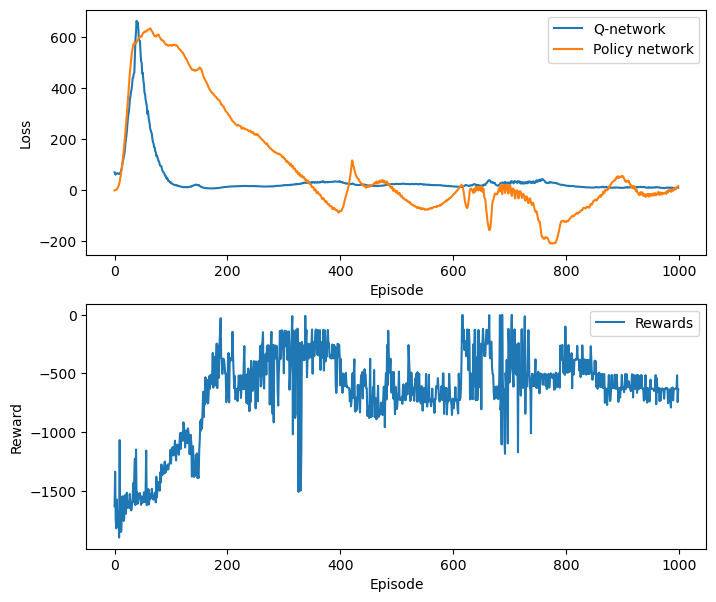

In [74]:
history_Q = np.load(net_dir+'/history_Q.npy')
history_policy = np.load(net_dir+'/history_policy.npy')
history_reward = np.load(net_dir+'/history_reward.npy')

fig, axs = plt.subplots(2,1,figsize=(8,7))

ax = axs[0]
ax.plot(history_Q)
ax.plot(history_policy)
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.legend(['Q-network','Policy network'])

ax = axs[1]
ax.plot(history_reward)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend(['Rewards'])

fig.savefig(f'Plots/DDPG_training_{len(history_Q)}.png')

Simulation

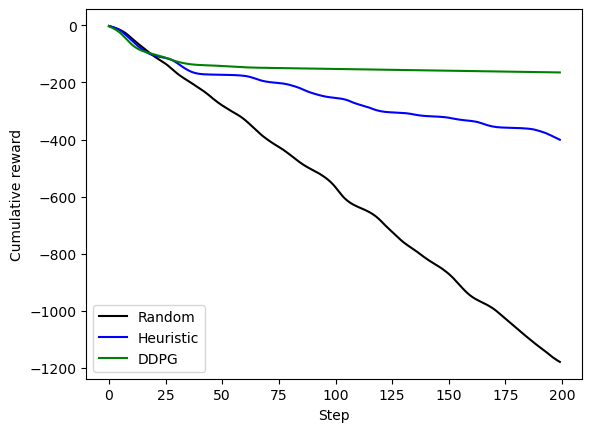

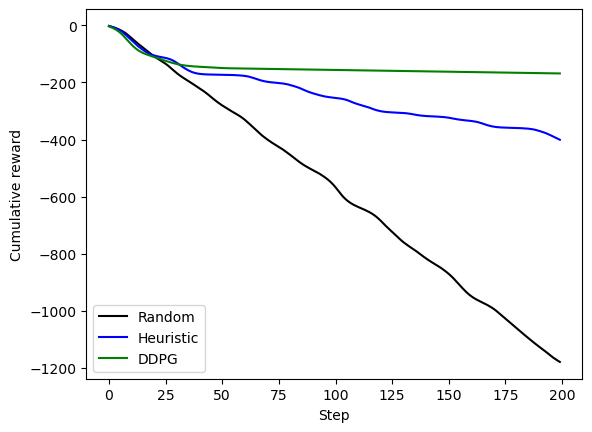

-1179.1281776355108 -400.7734470628552 -168.49711103386463


In [108]:
rewards = np.zeros((100,200))

for i in range(100):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = ddpg_agent.compute_action(state, deterministic = True) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

ddpg_rewards = rewards

plt.figure()
plt.plot(np.arange(200), np.mean(np.cumsum(rand_rewards, axis = 1), axis = 0),'k',label='Random')
plt.plot(np.arange(200), np.mean(np.cumsum(heur_rewards, axis = 1), axis = 0),'b', label='Heuristic')
plt.plot(np.arange(200), np.mean(np.cumsum(ddpg_rewards, axis = 1), axis = 0),'g', label='DDPG')
plt.xlabel('Step')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('Plots/DDPG_rewards.png')
plt.show()
print(np.mean(np.sum(rand_rewards, axis = 1), axis = 0), np.mean(np.sum(heur_rewards, axis = 1), axis = 0), np.mean(np.sum(ddpg_rewards, axis = 1), axis = 0))

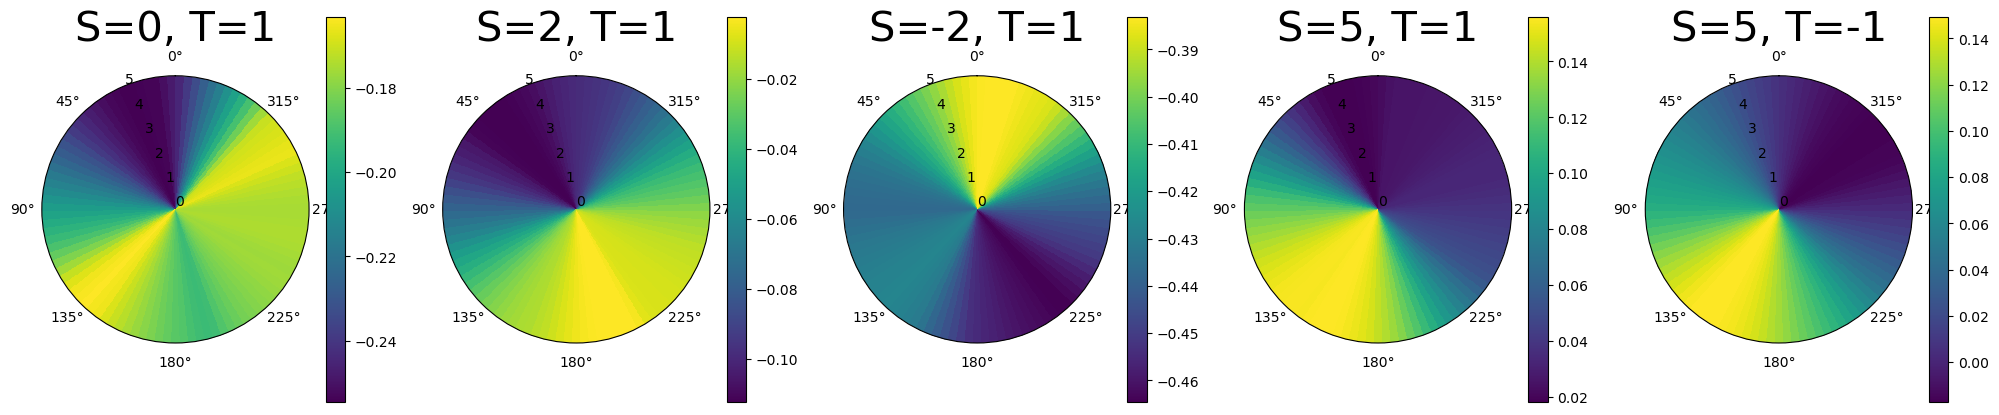

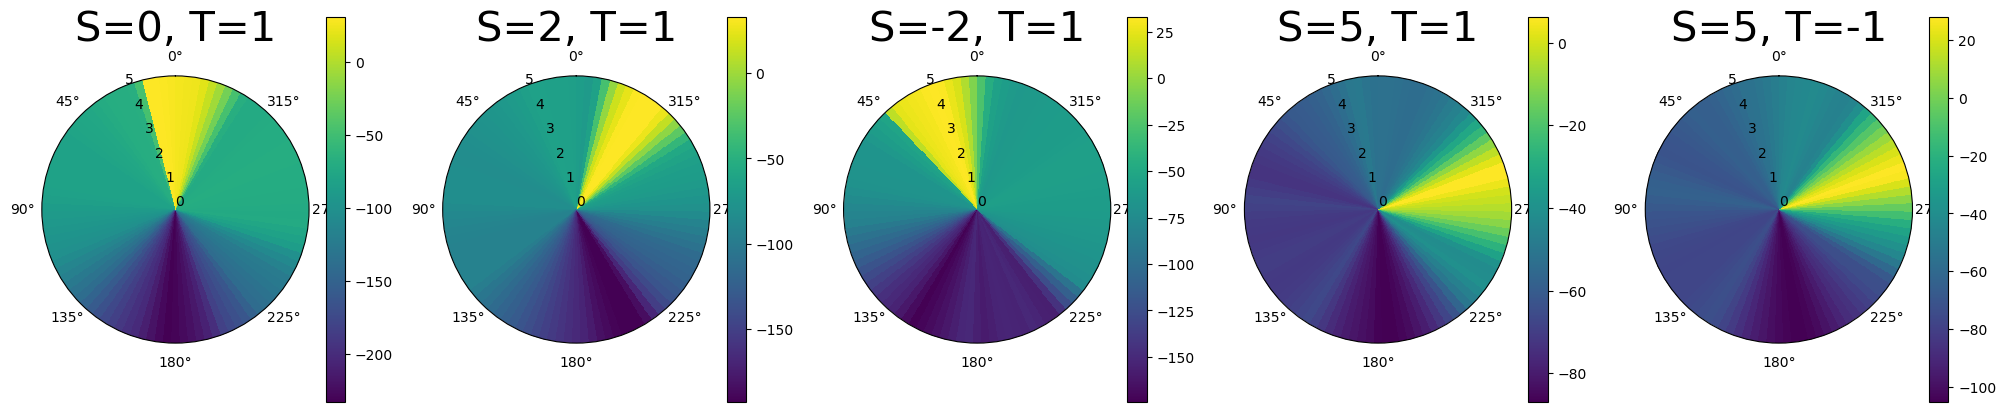

In [20]:
ddpg_agent_start = DDPGAgent(0.3)
ddpg_agent = DDPGAgent(0.3)
net_dir = 'Models/DDPG_network'
ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))

logs = [(0,1),(2,1),(-2,1),(5,1),(5,-1)]

fig, axs = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection': 'polar'})

for i,l in enumerate(logs):
    speed = l[0]
    torque = l[1]
    
    #fig = plt.figure(figsize=(20, 5))
    
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = ddpg_agent_start.Q_network(data)
    z = z.detach().numpy().squeeze()
    
    ax = axs[i]
    ax.grid(False)
    pc = ax.pcolormesh(th, r, z)
    ax.plot(azm, r, color='k', ls='none') 
    ax.set_theta_zero_location('N')
    fig.colorbar(pc, ax=ax)
    ax.set_title(f'S={speed}, T={torque}',fontsize=30)

plt.savefig(f'Plots/DDPG_heat_pre.png', bbox_inches='tight')
plt.show()


fig, axs = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection': 'polar'})


for i,l in enumerate(logs):
    speed = l[0]
    torque = l[1]
    
    #fig = plt.figure(figsize=(20, 5))
    
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = ddpg_agent.Q_network(data)
    z = z.detach().numpy().squeeze()
    
    ax = axs[i]
    ax.grid(False)
    pc = ax.pcolormesh(th, r, z)
    ax.plot(azm, r, color='k', ls='none') 
    ax.set_theta_zero_location('N')
    fig.colorbar(pc, ax=ax)
    ax.set_title(f'S={speed}, T={torque}',fontsize=30)


plt.savefig(f'Plots/DDPG_heat.png', bbox_inches='tight')
plt.show()

# 6) Target Networks

In [20]:
def train_epoch_ddpg_target(model_policy, model_Q, target_model_policy, target_model_Q, agent, optimizer_policy, optimizer_Q, criterion, gamma, Buffer, epoch):
    state = env.reset()
    state = state[0]

    Trunc = False
    loss_epoch_Q = []
    loss_epoch_policy = []
    cur_rew = 0
    while not Trunc:
        with torch.no_grad():
            action = agent.compute_action(state)
        (next_state, reward, term, Trunc, info) = env.step(action)
        cur_rew += reward
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
    
        if len(Buffer.buffer) >= 128:
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,4))
            reward = np.zeros(128)
            next_data = np.zeros((128,4))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):  
                data[i] = np.concatenate((transition[0], transition[1]))
                reward[i] = transition[2]
                trunc[i] = transition[4]
                with torch.no_grad(): 
                    next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3], deterministic = True, use_target = True)))

            data = torch.tensor(data, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)
            next_data = torch.tensor(next_data, dtype=torch.float32)
            trunc = torch.tensor(trunc, dtype = torch.bool)

            optimizer_Q.zero_grad()
            optimizer_policy.zero_grad()

            output_Q = model_Q(data)  # (state, action) -> Q
            with torch.no_grad():
                target = (reward + gamma*target_model_Q(next_data).flatten()).reshape(128,1)
            loss_Q = criterion(output_Q, target) 
            loss_Q.backward()
            optimizer_Q.step()

            output_policy = model_policy(data[:, :3])  # state -> action            
            loss_policy = compute_loss_policy(data[:, :3], output_policy, model_Q)
            loss_policy.backward()
            optimizer_policy.step()
            
            loss_epoch_Q.append(loss_Q.item())
            loss_epoch_policy.append(loss_policy.item())
            agent.update_target_params()

    return np.mean(loss_epoch_Q), np.mean(loss_epoch_policy), cur_rew

In [24]:
'''
def train_epoch_target(model, target_model, agent, optimizer, criterion, gamma, Buffer, epoch):
    #model.eval()
    state = env.reset()
    state = state[0]
    Trunc = False
    loss_epoch = []
    while not Trunc:
        with torch.no_grad():
            action = agent.compute_action(state) 
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
        #print(Buffer.buffer[-1])
        if (len(Buffer.buffer) >= 128):
            #model.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,4))
            reward = np.zeros(128)
            next_data = np.zeros((128,4))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):  
                data[i] = np.concatenate((transition[0], transition[1]))
                reward[i] = transition[2]
                trunc[i] = transition[4]
                with torch.no_grad():           
                    next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3], deterministic = True, use_target = True)))  ###### USE TARGET NETWORK

            data = torch.tensor(data, dtype=torch.float32)   
            reward = torch.tensor(reward, dtype=torch.float32)
            next_data = torch.tensor(next_data, dtype=torch.float32)
            trunc = torch.tensor(trunc, dtype = torch.bool)

            optimizer.zero_grad()

            output = model(data)  # (state, action) -> Q(s, a)
            with torch.no_grad():
                target = (reward + gamma*target_model(next_data).flatten()).reshape(128,1) ###### USE TARGET NETWORK
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
            
    return np.mean(loss_epoch)


def train_epoch_policy_target(model_policy, model_Q, target_model_policy, target_model_Q, agent, optimizer, criterion, gamma, Buffer, epoch):   
    state = env.reset()
    state = state[0]

    Trunc = False
    loss_epoch = []
    while not Trunc:
        #model_policy.eval()
        with torch.no_grad():
            action = agent.compute_action(state)
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
    
        if len(Buffer.buffer) >= 128:
            #model_Q.eval()
            #model_policy.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,3))
            reward = np.zeros(128)
            next_data = np.zeros((128,3))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):        
                data[i] = transition[0]
                reward[i] = transition[2]
                trunc[i] = transition[4]
                next_data[i] = transition[3]

            data = torch.tensor(data, dtype=torch.float32)   
            reward = torch.tensor(reward, dtype=torch.float32)
            next_data = torch.tensor(next_data, dtype=torch.float32)
            trunc = torch.tensor(trunc, dtype = torch.bool)
            optimizer.zero_grad()
            output = model_policy(data)  # state -> action
            
            loss = compute_loss_policy(data, output, model_Q)  #### USE TARGET Q NETWORK

            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())

    return np.mean(loss_epoch)
'''

In [ ]:
# Define DDPG agent
noise_std = 0.3
TAU = [0.01, 0.10, 0.25, 0.5, 0.75] 
plt.figure()
colors = ['k','r','g','y', 'b']

for col, tau in zip(colors,TAU):
    
    ddpg_agent = DDPGAgent(sigma = noise_std, tau = tau)
    max_size = 1e5
    Buffer = ReplayBuffer(max_size = max_size)
    
    # Training parameters, ecc...
    lr = 1e-4
    gamma = 0.99
    optimizer_Q = torch.optim.Adam(ddpg_agent.Q_network.parameters(), lr = lr)
    optimizer_policy = torch.optim.Adam(ddpg_agent.policy_network.parameters(), lr = lr)
    criterion_Q = torch.nn.MSELoss()
    num_epochs = 1000
    net_dir = 'Models/target_network/tau_'+str(tau)
    
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)

    try:
        no
        ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_Q_network.load_state_dict(torch.load(net_dir+'/target_Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_policy_network.load_state_dict(torch.load(net_dir+'/target_policy_network.pt', map_location=torch.device('cpu')))

        print('Loading network for tau = ', tau)
    except:    
        history_Q = []
        history_policy = []
        history_reward = []

        state = env.reset()
        state = state[0]

        for epoch in range(num_epochs):
            loss_Q, loss_policy, cur_rew = train_epoch_ddpg_target(ddpg_agent.policy_network, ddpg_agent.Q_network, ddpg_agent.target_policy_network, ddpg_agent.target_Q_network, 
                                                    ddpg_agent, optimizer_policy, optimizer_Q, criterion_Q, gamma, Buffer, epoch)

            if epoch%10 == 0:
                print(f'Epoch: {epoch}, loss Q: {loss_Q:.3f}, loss pol: {loss_policy:.3f}')
            history_Q.append(loss_Q)
            history_policy.append(loss_policy)
            history_reward.append(cur_rew)

        torch.save(ddpg_agent.Q_network.state_dict(), net_dir+'/Q_network.pt')
        torch.save(ddpg_agent.policy_network.state_dict(), net_dir+'/policy_network.pt')
        torch.save(ddpg_agent.target_Q_network.state_dict(), net_dir+'/target_Q_network.pt')
        torch.save(ddpg_agent.target_policy_network.state_dict(), net_dir+'/target_policy_network.pt')

        np.save(net_dir+'/history_Q.npy', history_Q)
        np.save(net_dir+'/history_policy.npy', history_policy)
        np.save(net_dir+'/history_reward.npy', history_reward)
        
        ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_Q_network.load_state_dict(torch.load(net_dir+'/target_Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_policy_network.load_state_dict(torch.load(net_dir+'/target_policy_network.pt', map_location=torch.device('cpu')))

    history_Q = np.load(net_dir+'/history_Q.npy')
    history_policy = np.load(net_dir+'/history_policy.npy')
    history_reward = np.load(net_dir+'/history_reward.npy')

    plt.plot(history_Q,col+'-',label=f'{tau}')
    plt.plot(history_policy,col+'--',label=f'{tau}')

plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'Plots/DDPG_training_target_{len(history_Q)}.png')

Epoch: 0, loss Q: 5.551, loss pol: -0.058
Epoch: 10, loss Q: 4.350, loss pol: 44.769
Epoch: 20, loss Q: 10.240, loss pol: 156.861
Epoch: 30, loss Q: 13.929, loss pol: 227.196
Epoch: 40, loss Q: 17.008, loss pol: 294.239


In [ ]:
tau = 0.5
net_dir = 'Models/target_network/tau_'+str(tau)

rewards = np.zeros((100,200))
ddpg_agent = DDPGAgent(sigma = noise_std, tau = tau)
ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
ddpg_agent.target_Q_network.load_state_dict(torch.load(net_dir+'/target_Q_network.pt', map_location=torch.device('cpu')))
ddpg_agent.target_policy_network.load_state_dict(torch.load(net_dir+'/target_policy_network.pt', map_location=torch.device('cpu')))


for i in range(100):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = ddpg_agent.compute_action(state, deterministic = True) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

ddpg_target_rewards = rewards

plt.figure()
plt.plot(np.arange(200), np.cumsum(rand_rewards[0]),'--k',label='Random')
plt.plot(np.arange(200), np.cumsum(heur_rewards[0]),'--b', label='Heuristic')
plt.plot(np.arange(200), np.cumsum(ddpg_rewards[0]),'g', label='DDPG')
plt.plot(np.arange(200), np.cumsum(ddpg_target_rewards[0]),'orange', label='DDPG with target')
plt.legend()
[plt.plot(np.arange(200), np.cumsum(rand_rewards[i]),'--k') for i in range(1,len(rand_rewards))]
[plt.plot(np.arange(200), np.cumsum(heur_rewards[i]),'--b') for i in range(1,len(heur_rewards))]
[plt.plot(np.arange(200), np.cumsum(ddpg_rewards[i]),'g') for i in range(1,len(ddpg_rewards))]
[plt.plot(np.arange(200), np.cumsum(ddpg_target_rewards[i]),'orange') for i in range(1,len(ddpg_target_rewards))]
plt.show()

# 7) Ornstein-Uhlenbeck Noise

In [ ]:
# Define DDPG agent
noise_std = 0.3
tau = 0.5 ### Change
THETA = [0.01, 0.10, 0.25, 0.5, 0.75] 
plt.figure()
colors = ['k','b','r','g','y']

for col, theta in zip(colors,THETA):
    ddpg_agent = DDPGAgent(sigma = noise_std, tau = tau, theta = theta, OUNoise = True)
    max_size = 1e5
    Buffer = ReplayBuffer(max_size = max_size)
    
    # Training parameters, ecc...
    lr = 1e-4
    gamma = 0.99
    optimizer_Q = torch.optim.Adam(ddpg_agent.Q_network.parameters(), lr = lr)
    optimizer_policy = torch.optim.Adam(ddpg_agent.policy_network.parameters(), lr = lr)
    criterion_Q = torch.nn.MSELoss()
    num_epochs = 1000
    net_dir = 'Models/OU_network/theta_'+str(theta)
    
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)

    try:
        no
        ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_Q_network.load_state_dict(torch.load(net_dir+'/target_Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_policy_network.load_state_dict(torch.load(net_dir+'/target_policy_network.pt', map_location=torch.device('cpu')))

        print('Loading network')
    except:    
        history_Q = []
        history_policy = []
        history_reward = []

        state = env.reset()
        state = state[0]

        for epoch in range(num_epochs):
            loss_Q, loss_policy, cur_rew = train_epoch_ddpg_target(ddpg_agent.policy_network, ddpg_agent.Q_network, ddpg_agent.target_policy_network, ddpg_agent.target_Q_network, 
                                                    ddpg_agent, optimizer_policy, optimizer_Q, criterion_Q, gamma, Buffer, epoch)

            if epoch%10 == 0:
                print(f'Theta: {theta}, Epoch: {epoch}, loss Q: {loss_Q:.3f}, loss pol: {loss_policy:.3f}')
            history_Q.append(loss_Q)
            history_policy.append(loss_policy)
            history_reward.append(cur_rew)

        torch.save(ddpg_agent.Q_network.state_dict(), net_dir+'/Q_network.pt')
        torch.save(ddpg_agent.policy_network.state_dict(), net_dir+'/policy_network.pt')
        torch.save(ddpg_agent.target_Q_network.state_dict(), net_dir+'/target_Q_network.pt')
        torch.save(ddpg_agent.target_policy_network.state_dict(), net_dir+'/target_policy_network.pt')

        np.save(net_dir+'/history_Q.npy', history_Q)
        np.save(net_dir+'/history_policy.npy', history_policy)
        np.save(net_dir+'/history_reward.npy', history_reward)
        
        ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_Q_network.load_state_dict(torch.load(net_dir+'/target_Q_network.pt', map_location=torch.device('cpu')))
        ddpg_agent.target_policy_network.load_state_dict(torch.load(net_dir+'/target_policy_network.pt', map_location=torch.device('cpu')))

    history_Q = np.load(net_dir+'/history_Q.npy')
    history_policy = np.load(net_dir+'/history_policy.npy')
    history_reward = np.load(net_dir+'/history_reward.npy')

    plt.plot(history_Q,col+'-',label=f'{tau}')
    plt.plot(history_policy,col+'--',label=f'{tau}')

plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'Plots/DDPG_training_OU_{len(history_Q)}.png')

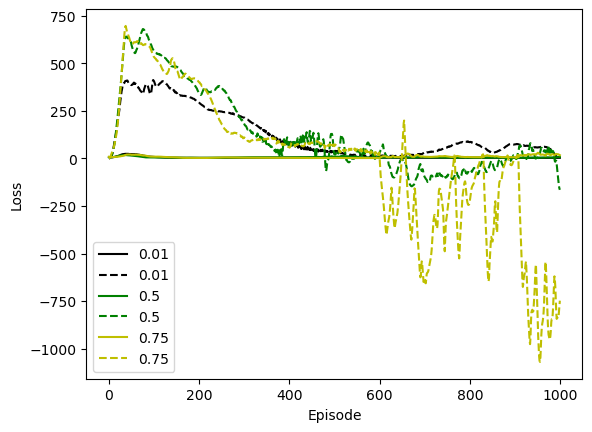

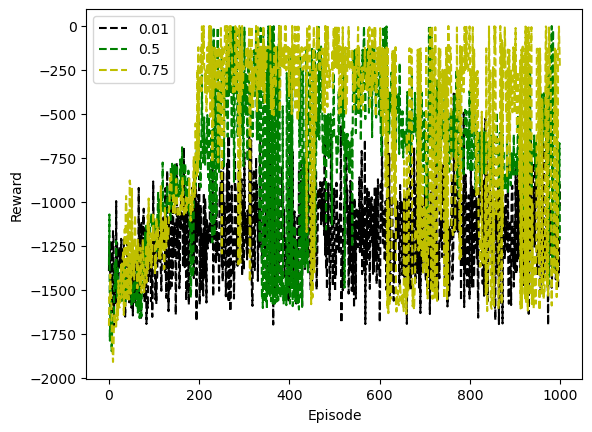

In [34]:
THETA = [0.01, 0.5, 0.75] 
colors = ['k','g','y']

plt.figure()
for col, theta in zip(colors,THETA):
    net_dir = 'Models/OU_network/theta_'+str(theta)
    history_Q = np.load(net_dir+'/history_Q.npy')
    history_policy = np.load(net_dir+'/history_policy.npy')
    
    plt.plot(history_Q,col+'-',label=f'{theta}')
    plt.plot(history_policy,col+'--',label=f'{theta}')
    
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(f'Plots/DDPG_training_OU_{len(history_Q)}.png')

plt.figure()
for col, theta in zip(colors,THETA):
    net_dir = 'Models/OU_network/theta_'+str(theta)
    history_reward = np.load(net_dir+'/history_reward.npy')
    
    plt.plot(history_reward,col+'--',label=f'{theta}')
    
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

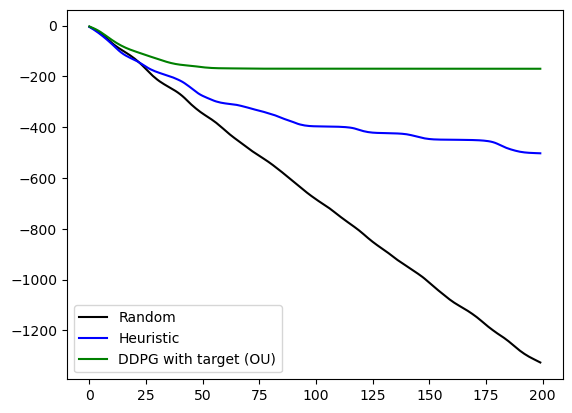

In [32]:
tau = 0.5
theta = 0.75
net_dir = 'Models/OU_network/theta_'+str(theta)

rewards = np.zeros((100,200))
ddpg_agent = DDPGAgent(sigma = noise_std, tau = tau, theta = theta, OUNoise = True)
ddpg_agent.Q_network.load_state_dict(torch.load(net_dir+'/Q_network.pt', map_location=torch.device('cpu')))
ddpg_agent.policy_network.load_state_dict(torch.load(net_dir+'/policy_network.pt', map_location=torch.device('cpu')))
ddpg_agent.target_Q_network.load_state_dict(torch.load(net_dir+'/target_Q_network.pt', map_location=torch.device('cpu')))
ddpg_agent.target_policy_network.load_state_dict(torch.load(net_dir+'/target_policy_network.pt', map_location=torch.device('cpu')))


rewards = np.zeros((100,200))

for i in range(100):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = ddpg_agent.compute_action(state, deterministic = True) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

ddpg_noise_rewards = rewards

# plt.figure()
# plt.plot(np.arange(200), np.cumsum(rand_rewards[0]),'--k',label='Random')
# plt.plot(np.arange(200), np.cumsum(heur_rewards[0]),'--b', label='Heuristic')
# plt.plot(np.arange(200), np.cumsum(ddpg_rewards[0]),'g', label='DDPG')
# plt.plot(np.arange(200), np.cumsum(ddpg_target_rewards[0]),'orange', label='DDPG with target')
# plt.plot(np.arange(200), np.cumsum(ddpg_noise_rewards[0]),'r', label='DDPG with target')

# plt.legend()
# [plt.plot(np.arange(200), np.cumsum(rand_rewards[i]),'--k') for i in range(1,len(rand_rewards))]
# [plt.plot(np.arange(200), np.cumsum(heur_rewards[i]),'--b') for i in range(1,len(heur_rewards))]
# [plt.plot(np.arange(200), np.cumsum(ddpg_rewards[i]),'g') for i in range(1,len(ddpg_rewards))]
# [plt.plot(np.arange(200), np.cumsum(ddpg_target_rewards[i]),'orange') for i in range(1,len(ddpg_target_rewards))]
# [plt.plot(np.arange(200), np.cumsum(ddpg_noise_rewards[i]),'r') for i in range(1,len(ddpg_noise_rewards))]

# plt.show()


plt.figure()
plt.plot(np.arange(200), np.mean(np.cumsum(rand_rewards, axis = 1), axis = 0),'k',label='Random')
plt.plot(np.arange(200), np.mean(np.cumsum(heur_rewards, axis = 1), axis = 0),'b', label='Heuristic')
# plt.plot(np.arange(200), np.mean(np.cumsum(ddpg_rewards, axis = 1), axis = 0),'g', label='DDPG')
# plt.plot(np.arange(200), np.mean(np.cumsum(ddpg_target_rewards, axis = 1), axis = 0),'g', label='DDPG with target')
plt.plot(np.arange(200), np.mean(np.cumsum(ddpg_noise_rewards, axis = 1), axis = 0),'g', label='DDPG with target (OU)')
plt.legend()
plt.savefig('OU_rewards.png')
plt.show()